In [18]:
# importing required libraries
import pandas as pd
import numpy as np
import math
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score

def chunk_preprocessing(chunk):
    #Removing rows with 0 pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
    d = np.where(chunk.pickup_longitude == 0)
    chunk = chunk.drop(chunk.index[d])
    d = np.where(chunk.pickup_latitude == 0)
    chunk = chunk.drop(chunk.index[d])
    d = np.where(chunk.dropoff_longitude == 0)
    chunk = chunk.drop(chunk.index[d])
    d = np.where(chunk.dropoff_latitude == 0)
    chunk = chunk.drop(chunk.index[d])

    #Replacing PICKUP_DATETIME column with corresponding insighful data
    chunk['pickup_datetime'] = pd.to_datetime(chunk['pickup_datetime'])
    chunk['Year'] = chunk.pickup_datetime.dt.year
    chunk['Month'] = chunk.pickup_datetime.dt.month
    chunk['Day'] = chunk.pickup_datetime.dt.day
    chunk['Hours'] = chunk.pickup_datetime.dt.hour
    chunk = chunk.drop(columns=['pickup_datetime'],axis=1)
    
    #Replacing Longitudes and Latitudes with their corresponding distances
    chunk['distance'] = haversine_distance(chunk['pickup_latitude'], chunk['pickup_longitude'], chunk['dropoff_latitude'], 
                                           chunk['dropoff_longitude'],)
    chunk = chunk.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'],axis=1)
    
    return chunk


def haversine_distance(lat1, long1, lat2, long2):
    R = 6371  #radius of earth in kilometers
    #R = 3959 #radius of earth in miles
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2-lat1)
    delta_lambda = np.radians(long2-long1)
    #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    #c = 2 * atan2( √a, √(1−a) )
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    #d = R*c
    d = (R * c) #in kilometers
    return abs(d)


# read the train and test dataset
train_data_chunk = pd.read_csv('train.csv', nrows = 10000000 , chunksize = 100000)
test_data_chunk = pd.read_csv('test.csv', nrows = 10000, chunksize = 100000)

#Train data
chunk_list = []                                  # append each chunk df here 
for chunk in train_data_chunk:                   # Each chunk is in df format
    chunk_filter = chunk_preprocessing(chunk)    # perform data preprocessing 
    chunk_list.append(chunk_filter)              # Once the data filtering is done, append the chunk to list

train_data = pd.concat(chunk_list)               # concat the list into dataframe 


#Test data
chunk_list = []                                  # append each chunk df here 
for chunk in test_data_chunk:                    # Each chunk is in df format
    chunk_filter = chunk_preprocessing(chunk)    # perform data preprocessing 
    chunk_list.append(chunk_filter)              # Once the data filtering is done, append the chunk to list
    
test_data = pd.concat(chunk_list)                # concat the list into dataframe 

# Removing KEY column
train_key = train_data['key']
test_key = test_data['key']
train_data = train_data.drop(columns=['key'],axis=1)
test_data = test_data.drop(columns=['key'],axis=1)
test_data = test_data.reset_index(drop=True)

# shape of the dataset
print('Shape of training data :',train_data.shape)
print('Shape of testing data :',test_data.shape)

Shape of training data : (4900254, 7)
Shape of testing data : (9914, 6)


Text(0, 0.5, 'Frequency')

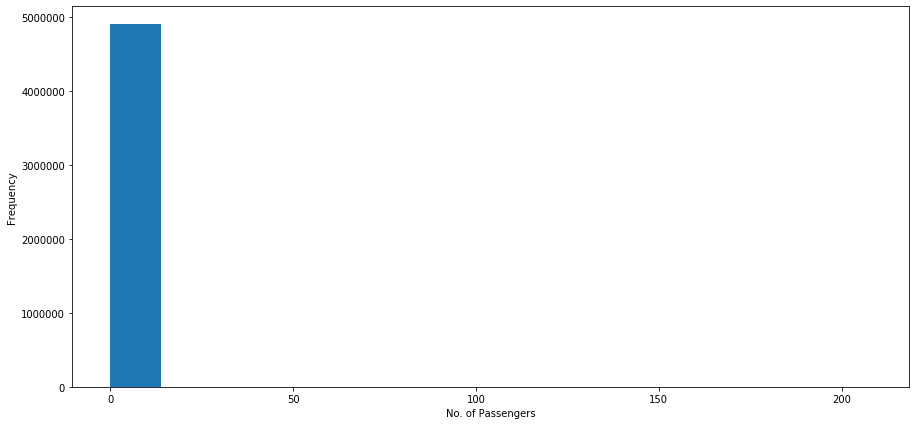

In [19]:
#Exploratory Data Analysis
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.hist(train_data['passenger_count'], bins=15)
plt.xlabel('No. of Passengers')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

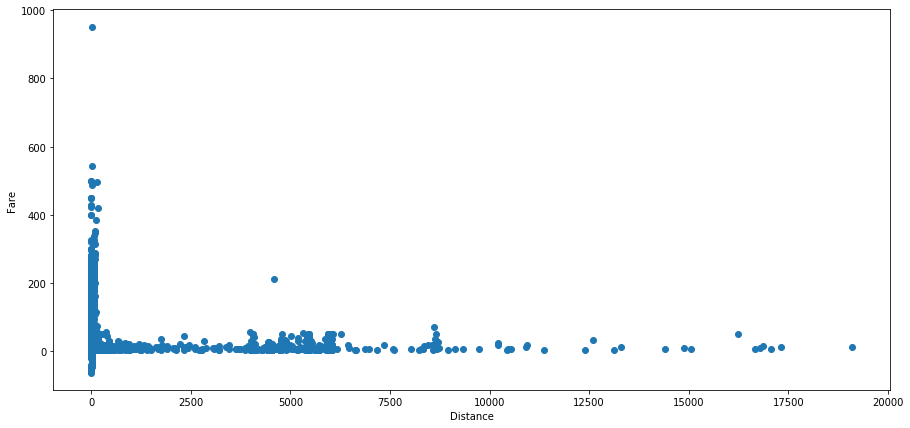

In [20]:
plt.figure(figsize=(15,7))
plt.scatter(x = train_data['distance'], y = train_data['fare_amount'])
plt.xlabel('Distance')
plt.ylabel('Fare')

From the above 2 graphs we can see that single passengers are the most frequent travellers, and the highest fare are paid for short distance travels

Text(0, 0.5, 'Fare')

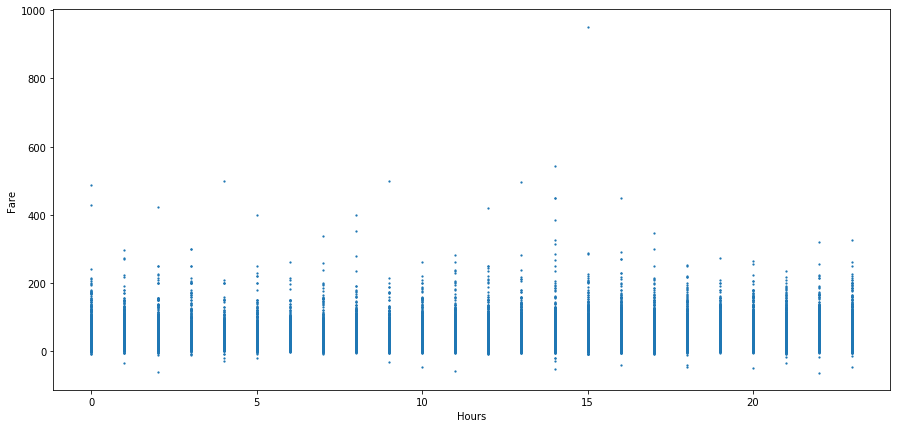

In [21]:
plt.figure(figsize=(15,7))
plt.scatter(x = train_data['Hours'], y = train_data['fare_amount'], s=1.5)
plt.xlabel('Hours')
plt.ylabel('Fare')

Interesting! The time of day definitely plays an important role. The frequency of cab rides seem to be the lowest at 5AM and the highest at 7PM.

In [22]:
# seperate the independent and target variable on training data
train_x = train_data.drop(columns=['fare_amount'],axis=1)
train_y = train_data['fare_amount']

In [23]:
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV


model = XGBRegressor(objective ='reg:squarederror')

n_estimators = [80, 90, 100, 110, 120, 130]
max_depth = [3, 4, 5, 6, 7, 8, 9, 10]
learning_rate = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

random_grid = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth,
    'learning_rate' : learning_rate
              }

model = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 2, cv = 2, 
                                 verbose=0, random_state=100 , n_jobs = -1)


# model = XGBRegressor(objective ='reg:squarederror', learning_rate = 0.6, 
#                      n_estimators = 125, max_depth = 8)

model.fit(train_x, train_y)
print('Model Fitted')

[19:57:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:57:28] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Model Fitted


In [24]:
#Determining the significant variables in the input data
#plot_importance(model)

# predict the target on the train dataset
predict_results = model.predict(test_data)
print('Results Predicted')

# Accuray Score on train dataset
#mse = mean_squared_error(np.ceil(train_y), np.ceil(predict_results))
#print("MSE: ",mse)

Results Predicted


In [25]:
xyz = pd.read_csv('test.csv')
test_key = xyz['key'].astype('str')

output = np.column_stack((np.array(test_key), np.array(predict_results)))
pd.DataFrame(output).to_csv("output.csv", header=None, index=None)